<a href="https://colab.research.google.com/github/adibayaseen/PPI-Inhibitors/blob/main/code/GNN_based_pipeline_Training_for_Predicting_small_molecule_inhibition_of_protein_complexes_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!rm -r Data
!rm -r PPI-Inhibitors
!pip install biopython
!git clone https://github.com/adibayaseen/PPI-Inhibitors
#!pip install py3Dmol

rm: cannot remove 'PPI-Inhibitors': No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:00
Cloning into 'PPI-Inhibitors'...
remote: Enumerating objects: 1253, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 1253 (delta 172), reused 394 (delta 129), pack-reused 805
Receiving objects: 100% (1253/1253), 2.59 GiB | 15.99 MiB/s, done.
Resolving deltas: 100% (354/354), done.
Updating files: 100% (596/596), done.


In [4]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.1 MB/s eta 0:00:00


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 16:43:15 2024

@author: u1876024
"""


import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

class BalancedDataset(Dataset):
    """
    A custom dataset class that creates a balanced dataset from imbalanced data.
    This dataset calculates sample weights inversely proportional to class frequencies,
    which can be used with a WeightedRandomSampler to achieve balanced batches.

    NOTE: As it involves stochastic sampling, there is a chance that a few training examples are actually never selected.

    Attributes:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        sample_weights (torch.Tensor): Weights for each sample, inversely proportional to class frequencies.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__(idx): Returns the sample and its corresponding label at the given index.
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        # Count the number of examples in each class
        class_counts = np.bincount(self.labels)
        # Assign weight inversely proportional to class frequency
        weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        # Create a weight list for each sample
        self.sample_weights = weights[labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_balanced_loader(data, labels, batch_size=32):
    """
    Creates a DataLoader with balanced batches for a given dataset.
    This function is useful for training models on imbalanced datasets.

    Args:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        batch_size (int, optional): The size of each batch. Default is 32.

    Returns:
        DataLoader: A PyTorch DataLoader that yields balanced batches.

    Usage Example:
        >>> data = [features1, features2, ...]  # Replace with your data features
        >>> labels = [label1, label2, ...]     # Replace with your data labels
        >>> balanced_loader = create_balanced_loader(data, labels, batch_size=32)
        >>> for batch_data, batch_labels in balanced_loader:
        >>>     # Train your model using the balanced batches
    """
    dataset = BalancedDataset(data, labels)
    # WeightedRandomSampler will take care of the balancing
    sampler = WeightedRandomSampler(weights=dataset.sample_weights, num_samples=len(dataset.sample_weights), replacement=True)

    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return loader


class BinaryBalancedSampler(Sampler):
    """
    A PyTorch Sampler that returns batches with an equal number of positive and negative examples.
    The sampler oversamples from the minority class to balance the majority class, ensuring that
    each batch contains 50% positive and 50% negative examples.

    NOTE: It leads to more examples in single iteration through the data loader than in one epoch

    Attributes:
        class_vector (list or numpy array): class labels.
        batch_size (int): The size of each batch.
        n_splits (int): The number of batches/splits in the dataset.
        equivalent_epochs (float): The number of times the sampler goes over the minority class
                                   in one complete iteration of the DataLoader.

    Methods:
        gen_sample_array: Yields indices for each batch ensuring class balance.
        __iter__: Returns an iterator over batch indices.
        __len__: Returns the number of batches in the sampler.
    """
    def __init__(self, class_vector, batch_size = 10):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        """
        self.batch_size = batch_size
        self.class_vector = class_vector
        YY = np.array(self.class_vector)
        U, C = np.unique(YY, return_counts=True)
        M = U[np.argmax(C)]        #find majority class
        Midx = np.nonzero(YY==M)[0] #indices of majority class
        midx = np.nonzero(YY!=M)[0] #indices of minority class
        midx_ = np.random.choice(midx,size=len(Midx))     #oversample minority indices so they are equal to majority ones
        self.YY = np.array(list(YY[Midx])+list(YY[midx_]))
        self.idx = np.array(list(Midx)+list(midx_))
        self.n_splits = int(np.ceil(len(self.idx)/self.batch_size))
        self.equivalent_epochs = len(self.idx)/len(self.class_vector)
        print('Equivalent epochs in one iteration of data loader',self.equivalent_epochs)

    def gen_sample_array(self):
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits= self.n_splits,shuffle=True)
        for tridx,ttidx in skf.split(self.idx,self.YY):
            yield np.array(self.idx[ttidx])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return self.n_splits

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

if __name__=='__main__':

    E = [(str(p_i), str(-1*c_i)) for p_i, c_i in zip(range(100), range(100))]  # Replace with your data
    Y = np.random.randint(0, 2, size=100)  # Replace with your labels
    batch_size = 10

    dataset = CustomDataset(E, Y)
    batch_sampler = BinaryBalancedSampler(Y, batch_size)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    for batch in data_loader:
        print(batch)

    # Example usage of create_balanced_loader
    balanced_loader = create_balanced_loader(E, Y, batch_size)

    # Iterate over the DataLoader
    L = []
    for (pid,cid),label in balanced_loader:
        # Process your batches
        L.extend(pid)
    print(L)


Equivalent epochs in one iteration of data loader 1.08
[[('11', '20', '33', '53', '89', '6', '90', '47', '32', '12'), ('-11', '-20', '-33', '-53', '-89', '-6', '-90', '-47', '-32', '-12')], tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]
[[('39', '42', '57', '81', '93', '75', '30', '86', '12', '76'), ('-39', '-42', '-57', '-81', '-93', '-75', '-30', '-86', '-12', '-76')], tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]
[[('35', '44', '45', '64', '97', '48', '69', '69', '3', '75'), ('-35', '-44', '-45', '-64', '-97', '-48', '-69', '-69', '-3', '-75')], tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]
[[('9', '49', '91', '96', '99', '67', '22', '63', '61', '2'), ('-9', '-49', '-91', '-96', '-99', '-67', '-22', '-63', '-61', '-2')], tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]
[[('4', '8', '13', '51', '74', '86', '90', '78', '78', '69'), ('-4', '-8', '-13', '-51', '-74', '-86', '-90', '-78', '-78', '-69')], tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])]
[[('24', '29', '34', '72', '87', '43', '92', '86', '15', '38'), ('-24', 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 13:06:21 2024

@author: u1876024
"""

import warnings
from Bio.PDB import *
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pdb
import warnings
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
from Bio.PDB import *
import warnings
from Bio.PDB import *
import numpy as np
from Bio.PDB.NeighborSearch import NeighborSearch
from tqdm import tqdm as tqdm
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pandas as pd
import random
from sklearn.metrics import auc,precision_recall_curve
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
import pickle
from rdkit import Chem
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
USE_CUDA = torch.cuda.is_available()
from torch.autograd import Variable
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

'''
Using Sklearn One hot encoder to encode the atoms
Output is of size N*M where N is the total number of atoms and M is the total number of encoded features
'''
def atom1(structure):
    atomslist=np.array(sorted(np.array(['C', 'CA', 'CB', 'CG', 'CH2', 'N','NH2',  'OG','OH', 'O1', 'O2', 'SE','1']))).reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(atomslist)
    atom_list=[]
    for atom in structure.get_atoms():
        if atom.get_name() in atomslist:
            atom_list.append(atom.get_name())
        else:
            atom_list.append("1")
    atoms_onehot=enc.transform(np.array(atom_list).reshape(-1,1)).toarray()
    return atoms_onehot
##############
'''
One hot encoded residue infomration using SKlearn Library

Output is N*M where N is the total number of atoms and M is the encoded features of the residues.
Any unknown  residue is mapped to 1
'''


def res1(structure):
    residuelist=np.array(sorted(np.array(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'CYS', 'HIS','1']))).reshape(-1,1)
    encr = OneHotEncoder(handle_unknown='ignore')
    encr.fit(residuelist)
    residue_list=[]
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() in residuelist:
            residue_list.append((atom.get_parent()).get_resname())
        else:
            residue_list.append("1")

    res_onehot=encr.transform(np.array(residue_list).reshape(-1,1)).toarray()

    return res_onehot
###########

'''
It calculates the neighbours of each atom i.e. 10 distinct neighbours
Output is  in the form of a ditionary representing an  adjacency list where each source atom and neighbouring atom is represented bby its sequence index .
'''


def neigh1(structure):
    #atom_list is a numpy array  that   contains all the atoms of the pdb file in atom object
    atom_list=np.array([atom for atom in structure.get_atoms()])

    #for atom in structure.get_atoms():
    #    atom_list.append(atom)
    #neighbour_list contains all the  neighbour atomic pairs  i.e. like if N has neighbours O and C then it is stored as [[N,C],[N,O]] i.e. has dimension N*2 where N is the total number of possible neighbours all the atoms have in an unsorted manner and it stores in the form of  atom object


    p4=NeighborSearch(atom_list)
    neighbour_list=p4.search_all(6,level="A")
    neighbour_list=np.array(neighbour_list)

    #dist is the distance between the neighbour and the source atom  i.e. dimension is N*1
    dist=np.array(neighbour_list[:,0]-neighbour_list[:,1])
    #sorting in ascending order
    place=np.argsort(dist)
    sorted_neighbour_list=neighbour_list[place]

    #old_atom_number is used for  storing atom id of the original protein before sorting
    #old_residue_number is used for storing residue number of the original protein before sorting
    source_vertex_list_atom_object=np.array(sorted_neighbour_list[:,0])
    len_source_vertex=len(source_vertex_list_atom_object)
    neighbour_vertex_with_respect_each_source_atom_object=np.array(sorted_neighbour_list[:,1])
    old_atom_number=[]
    old_residue_number=[]
    for i in atom_list:
        old_atom_number.append(i.get_serial_number())
        old_residue_number.append(i.get_parent().get_id()[1])
    old_atom_number=np.array(old_atom_number)
    old_residue_number=np.array(old_residue_number)
    req_no=len(neighbour_list)
    total_atoms=len(atom_list)
    #neigh_same_res is the 2D numpy array to store the indices of the  neighbours of  same residue and is of the shape N*10 where N is the total number of atoms
    #neigh_diff_res is 2D numpy array to store  the indices of the  neighbours of different residue
    #same_flag is used to restrict the neighbours belonging to same residue  to 10
    #diff_flag is used to restrict the neighbours belonging to different residue to 10
    neigh_same_res=np.array([[-1]*10 for i in range(total_atoms)])
    neigh_diff_res=np.array([[-1]*10 for i in range(total_atoms)])
    same_flag=[0]*total_atoms
    diff_flag=[0]*total_atoms
    for i in range(len_source_vertex):
        source_atom_id=source_vertex_list_atom_object[i].get_serial_number()
        neigh_atom_id=neighbour_vertex_with_respect_each_source_atom_object[i].get_serial_number()
        source_atom_res=source_vertex_list_atom_object[i].get_parent().get_id()[1]
        neigh_atom_res=neighbour_vertex_with_respect_each_source_atom_object[i].get_parent().get_id()[1]
        #finding out index of the source and neighbouring atoms from the original atom array with respect to their residue id and atom id
        temp_index1=np.where(source_atom_id==old_atom_number)[0]

        temp_index2=np.where(neigh_atom_id==old_atom_number)[0]
        for i1 in temp_index1:
            if old_residue_number[i1]==source_atom_res:
                source_index=i1
                break
        for i1 in temp_index2:
            if old_residue_number[i1]==neigh_atom_res:
                neigh_index=i1
                break
        #if both the residues are same

        if source_atom_res==neigh_atom_res :

            #limiting the number of neighbours of same residue to 10

            if int(same_flag[source_index])< 10:
                neigh_same_res[source_index][same_flag[source_index]]=neigh_index
                same_flag[source_index]+=1

            if int(same_flag[neigh_index])< 10:
                neigh_same_res[neigh_index][same_flag[neigh_index]]=source_index
                same_flag[neigh_index]+=1

        # if both the residues are different
        elif source_atom_res!=neigh_atom_res :

            #limiting the number of neighbours of different residues to 10

            if int(diff_flag[source_index])< 10:
                neigh_diff_res[source_index][diff_flag[source_index]]=neigh_index
                diff_flag[source_index]+=1


            if int(diff_flag[neigh_index])< 10:

                neigh_diff_res[neigh_index][diff_flag[neigh_index]]=source_index
                diff_flag[neigh_index]+=1




    return neigh_same_res,neigh_diff_res


if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")
class GNN_Layer(nn.Module):

    def __init__(self, filters, v_feats, trainable=True, **kwargs):
        #pdb.set_trace()
        super(GNN_Layer, self).__init__()
        self.v_feats = v_feats
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device=device
        self.Wsv = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10
        #print("Wsv shape",self.Wsv.shape)

    def forward(self, x):
        #pdb.set_trace()
        Z,same_neigh,diff_neigh = x
        node_signals = Z@self.Wsv
        neigh_signals_same=Z@self.Wsr
        neigh_signals_diff=Z@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal = (torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal = (torch.sum(diff_neigh_features, axis=1))/diff_norm
        final_res = torch.relu(node_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res,same_neigh,diff_neigh

class GNN_First_Layer(nn.Module):

    def __init__(self, filters, trainable=True, **kwargs):

        super(GNN_First_Layer, self).__init__()
        self.filters = filters
        #pdb.set_trace()
        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device
        self.Wv = nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wr = nn.Parameter( torch.randn(21,self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10


    def forward(self, x):
        atoms, residues,same_neigh,diff_neigh = x
        node_signals = atoms@self.Wv
        residue_signals = residues@self.Wr
        neigh_signals_same=atoms@self.Wsr
        neigh_signals_diff=atoms@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        """
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(1)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(1)
        """
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        #print("same norm",same_neigh > -1, 1)
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)
        same_norm = torch.sum(same_neigh > -1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1).type(torch.float)
        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal=(torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal=(torch.sum(diff_neigh_features, axis=1))/diff_norm

        final_res = torch.relu(node_signals+residue_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res, same_neigh,diff_neigh


class Dense(nn.Module):
    def __init__(self, in_dims, out_dims, trainable=True, **kwargs):
        #pdb.set_trace()
        super(Dense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device

        self.W = nn.Parameter( torch.randn(self.in_dims, self.out_dims, device=self.cuda_device,requires_grad=True))

    def forward(self, x):
        #pdb.set_trace()
        Z = torch.sigmoid(torch.matmul(x, self.W))

        return Z

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GNN_First_Layer(filters=512)
        self.conv2 = GNN_Layer(v_feats=512, filters=1024)
        self.conv3 = GNN_Layer(v_feats=1024, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(x1)
        x3=self.conv3(x2)
        x=x3[0]
        x=torch.sum(x,axis=0).view(1,-1)
        x = F.normalize(x)
        return x

    def processProtein(UniqueProtein, PdBloc):#, PdBloc):
        data_list = []

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        PData_dict={}
        for i in range(len(UniqueProtein)):
            #print('Converting PDB to Graph: {}/{}'.format(i+1, len(UniqueProtein)))
            UniqueProtein[i]=UniqueProtein[i].split('.pdb')[0]
            P1=PdBloc+UniqueProtein[i]+'.pdb'
            #if P1 in UniqueProtein:
            parser = PDBParser()
            with warnings.catch_warnings(record=True) as w:
              structure = parser.get_structure("", P1)
            one_hot_atom=(atom1(structure))

            one_hot_res=(res1(structure))
            neigh_same_res,neigh_diff_res=(neigh1(structure))
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            one_hot_atom=torch.tensor(one_hot_atom,dtype=torch.float32).to(device)
            one_hot_res=torch.tensor(one_hot_res,dtype=torch.float32).to(device)
            neigh_same_res=torch.tensor(neigh_same_res).to(device).long()
            neigh_diff_res=torch.tensor(neigh_diff_res).to(device).long()
            GNNData = [one_hot_atom,one_hot_res,neigh_same_res,neigh_diff_res]
            PData_dict[UniqueProtein[i]]= GNNData
        return PData_dict
def readFile(filename):
  with open(filename) as f:
    D = f.readlines()
  Name=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
      Name.append(name);PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);labels.append(float (y));
  return  PdbId,Ligandnames,SMILES,labels
class IPPI_MLP_Net(nn.Module):
    def __init__(self):
        super(IPPI_MLP_Net, self).__init__()
        self.fc1 = nn.Linear(2840, 1024)#4096)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)
        self.fc6 = nn.Linear(100, 1)
    def forward(self, PFeatures,LigandFeatures,ProteinInterfaceF):
          Cfeatures=LigandFeatures
          P_all_Features=torch.hstack((PFeatures,ProteinInterfaceF))
          PC_Features=torch.hstack((P_all_Features,Cfeatures))
          x = torch.tanh(self.fc1(PC_Features))
          x = torch.tanh(self.fc2(x))
          x = torch.relu(self.fc3(x))
          x = self.fc6(x)
          return x

#path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
path,githubpath='./','./PPI-Inhibitors/'
"""
path = location of pkl files from these links:
https://drive.google.com/file/d/1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW/view
https://drive.google.com/file/d/1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE/view

githubpath =  location of the directory containing the github repo PPI-Inhibitors
obtained using
git clone https://github.com/adibayaseen/PPI-Inhibitors
"""
Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
Pos_seqandInterfaceF_dict=pickle.load(open(githubpath+'Features/Pos_seqandInterfaceF_dict.npy',"rb"))
Complex_AllFeatures_dict=dict( list (Pos_seqandInterfaceF_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
##############
ComplexInterfaceFeatures={}
for key in Complex_AllFeatures_dict:
  if len(key.split('_'))>1:
    compname=key.split('_')[0]
    ComplexInterfaceFeatures[compname]=Complex_AllFeatures_dict[key]#.cuda()
  else:
    ComplexInterfaceFeatures[key]=Complex_AllFeatures_dict[key]#.cuda()
CompoundFingerprintFeaturesDict=pickle.load(open(githubpath+'Features/Compound_Fingerprint_Features_Dict.npy',"rb"))
#Load Protein data for GNN
path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
ProteinDataGNN_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
DBD5_ProteinDataGNN_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
All_ProteinData_dict=dict( list (ProteinDataGNN_dict.items())+list (DBD5_ProteinDataGNN_dict.items()))
for d in All_ProteinData_dict:
  data=All_ProteinData_dict[d]
  All_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
#########
with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt') as f:
#with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN.txt') as f:
    D = f.readlines()
Labels=[];Ligandnames=[];Complexs=[];TestPoscomplexes=[];#SMILESlist=[];
for d in tqdm(D):
  if len(d.split())==4:
      TestPoscomp,Complexname,Ligandname,label = d.split()
  else:
      TestPoscomp,Complexname,Ligandname,label = d.split()[0],d.split()[1],(' ').join(d.split()[2:-1]),d.split()[-1]
  TestPoscomplexes.append(TestPoscomp),Ligandnames.append(Ligandname);Complexs.append(Complexname);Labels.append(float (label))
#########Make dictionary, Rootcomplexname=(complexname,compoundname),label
Allexamples=dict (zip(zip(TestPoscomplexes,zip(Complexs,Ligandnames)),Labels))
#Group kfold
Alldata=list (Allexamples.keys())
KK=[k[0].split('_')[0] for k in Alldata]
groups = pd.DataFrame(KK)
gkf = GroupKFold(n_splits=len(set (KK)))
###########
AUC_ROC_final=[];Avg_P_final=[];Z=[];Yo=[];Y_t=[];Y_score=[];
from os import listdir
AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];Y_score=[];Y_t=[];classratio_dict={};
AUC_ROC_final=[];Avg_P_final=[];
Complexs,Ligandnames, Labels=np.array(Complexs),np.array(Ligandnames),np.array(Labels)
Alldata=np.array(Alldata)
classratio_dict=pickle.load(open(githubpath+'Features/Classratio_GNNdict.npy','rb'))

#%% Cross-validation
Done=set(KK).difference(['3D9T','1BKD','4ESG','2FLU','1YCQ','2XA0','3TDU','3D9T','2B4J','3DAB','3UVW','2RNY','4AJY', '1F47','1YCR','4QC3','1NW9','2E3K','4YY6','4GQ6','3WN7','1BXL','1Z92'])
for trainindex, testindex in gkf.split(KK, KK, groups=groups):
    train,test=Alldata[trainindex],Alldata[testindex]

    if test[0][0].split('_')[0] in Done:
      continue

    Ctr=[];Ptr=[];y_train=[];Ctrname=[];Ptrname=[];Xtr=[];G=[];Cttname=[];Ctt=[];y_test=[];Ptt=[];Pttname=[];
    #Split train and test
    for t in train:
        Ctrname.append(t[1][1]);Ctr.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        #change this only for GNN Complex_AllFeatures_dict with All_ProteinData_dic and t
        #####
        GNNcomp=t[1][0].split('_')[0]#t[1][0].split('_')[0]
        Ptrname.append(GNNcomp);Ptr.append(ComplexInterfaceFeatures[GNNcomp]);
        y_train.append(Allexamples[t[0],t[1]])
    #Split train and test
    for t in test:
        GNNcomp=t[1][0].split('_')[0]
        Cttname.append(t[1][1]);Ctt.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        Pttname.append(GNNcomp);Ptt.append(ComplexInterfaceFeatures[GNNcomp]);
        y_test.append(Allexamples[t[0],t[1]])
    #standarization
    Pscaler = StandardScaler().fit(Ptr)
    Cscaler = StandardScaler().fit(Ctr)
    Ctr = Cscaler.transform(Ctr)
    Ptr=Pscaler.transform(Ptr)
    Ptt=Pscaler.transform(Ptt)
    Ptrdict=dict (zip(Ptrname,torch.FloatTensor(Ptr).cuda()))
    Ctrdict=dict (zip (Ctrname,torch.FloatTensor( Ctr).cuda()))
    Ctt = Cscaler.transform(Ctt)
    Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
    Pttdict=dict (zip(Pttname,torch.FloatTensor(Ptt).cuda()))

    y_train = np.array(y_train)

    IPPI_Net = IPPI_MLP_Net().cuda()

    GNN_model=GNN().cuda()
    Mcomplexname=test[0][0].split('_')[0]
    criterion  = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list (IPPI_Net.parameters()) + list( GNN_model.parameters()),lr=0.001,weight_decay=0.0)#001)#0.69 for 1mer single layer#, weight_decay=0.01, betas=(0.9, 0.999))

    bsize = 1024



    dataset = CustomDataset(train[:,1], y_train.astype('int'))
    batch_sampler = BinaryBalancedSampler(y_train.astype('int'), bsize)
    loader = DataLoader(dataset, batch_sampler=batch_sampler) # data loader that selects equal number of positive and negative examples

    test_dataset = CustomDataset(test[:,1], np.array(y_test).astype('int'))
    test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False)


    #y_train=torch.FloatTensor( y_train).cuda()
    ####
    print ("test complex ", Mcomplexname)

    Loss = [] #save loss values for plotting
    E = [] #save examples
    L = [] #save labels
    terminated = False
    best_result = 0.0
    best_model = None
    counter = 0
    early_stop_count = 0
    Zlist,Ylist=[],[]
    for iters in tqdm(range(5)):
        for (batch_pids,batch_cids),batch_labels in tqdm(loader):
            GNN_model.train()
            IPPI_Net.train()
            E.extend(zip(batch_pids,batch_cids))
            L.append(batch_labels)
            pids = [p.split('_')[0] for p in batch_pids]
            G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
            GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
            del G_dict #clear up memory
            interface_features = torch.vstack([Ptrdict[p] for p in pids])
            compound_features = torch.vstack([Ctrdict[c] for c in batch_cids])
            #[GNN_model(All_ProteinData_dict[p]) for p in set_pids]
            output = IPPI_Net(GNN_features,compound_features,interface_features)
            V = np.min(list(classratio_dict.values()))
            weights = toTensor(np.array([classratio_dict[p]/V if batch_labels[i]==1 else 1.0 for i,p in enumerate(pids)  ]))
            criterion  = nn.BCEWithLogitsLoss(weight = None)
            loss = criterion(output.flatten(), batch_labels.float().cuda())
            Loss.append(loss.item())
            #if np.median(Loss[-10:])<1e-1: terminated = True
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            early_stop_count += 1
            #%% Validation/Testing (saves the best model in every 10 iterations over the validation set)
            GNN_model.eval()
            IPPI_Net.eval()
            Z, Y = [], []
            with torch.no_grad():
                for (batch_pids,batch_cids),batch_labels in test_loader:
                    pids = [p.split('_')[0] for p in batch_pids]
                    G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                    GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                    del G_dict #clear up memory
                    interface_features = torch.vstack([Pttdict[p] for p in pids])
                    compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                    output = IPPI_Net(GNN_features,compound_features,interface_features)
                    Z.extend(output.cpu().flatten().numpy())
                    Y.extend(batch_labels.cpu().flatten().numpy())
                aucroc = roc_auc_score(np.array(Y), np.array(Z))
                aucpr = average_precision_score(Y,Z)
                if aucroc>best_result:
                    early_stop_count = 0
                    best_result = aucroc
                    best_model = (GNN_model.state_dict(),IPPI_Net.state_dict())
                    IPPI_Net.load_state_dict(best_model[1])#path+'/newIPPI_Net_'+test[0][0].split('_')[0]+'_AUC_'+str (round (best_result,3)))#torch.load(path+'IPPI_Net_'+ Mcomplexname)[1])
                    GNN_model.load_state_dict(best_model[0])
                    GNN_model.eval()
                    IPPI_Net.eval()
                    Zb, Yb = [], []
                    for (batch_pids,batch_cids),batch_labels in test_loader:
                      pids = [p.split('_')[0] for p in batch_pids]
                      G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                      GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                      del G_dict #clear up memory
                      interface_features = torch.vstack([Pttdict[p] for p in pids])
                      compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                      bestmodeloutput=IPPI_Net(GNN_features,compound_features,interface_features)
                      #torch.save(Loss, path+'/Loss_'+test[0][0].split('_')[0])
                      Zb.extend(bestmodeloutput.cpu().flatten().numpy())
                      Yb.extend(batch_labels.cpu().flatten().numpy())
                    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
                    aucprb = average_precision_score(Yb,Zb)
                    print('LOADED BEST AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')
                    aucpr = average_precision_score(Y,Z)
                    print('AUCROC',aucroc,'AUCPR',aucpr,'best aucroc',best_result)
    ###Load best model
    print ("OUTSIDE LOOP AUC of Best")
    torch.save(best_model[1], path+'/GNN-based-pipeline_IPPI_Net_'+ test[0][0].split('_')[0])
    torch.save(best_model[0], path+'/GNN-based-pipeline_GNN_model_'+ test[0][0].split('_')[0])
    Zlist.extend(Zb);Ylist.extend(Yb)
    np.save(path+test[0][0].split('_')[0]+'Scores',Zb)
    np.save(path+test[0][0].split('_')[0]+'Targets',Yb)
    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
    aucprb = average_precision_score(Yb,Zb)
    print('Complex name',test[0][0].split('_')[0],'AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')
fpr, tpr, thresholds = roc_curve(Ylist, Zlist)
Auc = roc_auc_score(Ylist, Zlist)
Auc=(Auc).round(2)
# calculate precision-recall curve
Zlist=np.array(Zlist);Yo=np.array(Ylist);
#Y_t=np.array(Y_t);Y_score=np.array(Y_score)
precision, recall, thresholds = precision_recall_curve(Ylist, Zlist)
aucpr=average_precision_score (Ylist, Zlist)
########
np.save(path+'GNN-pipeline_Targets.npy',Ylist)
np.save(path+'GNN-pipeline_Scores.npy',Zlist)
######+
fig = plt.figure()
plt.plot(recall,precision,color='m',marker=',',label='AUC-PR:{: .2f}'.format(aucpr))
plt.title('AUC-PR');plt.xlabel('recall');plt.ylabel('precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUC-PR for PPI Inhibitors.pdf", bbox_inches='tight')
###
aucpr=(aucpr).round(2)
print("AucROC and aucpr Over all complexes \n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])))#,"\n")
#######
fig = plt.figure()
plt.plot(fpr,tpr,color='k',marker='d',label='AUC:{: .2f}'.format(Auc))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUCROC for vPPI Inhibitors.pdf", bbox_inches='tight')
###
print("Final average over all folds,Leave one complex out",p.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))

CUDA is available. Number of GPUs: 1
GPU 0: Tesla T4


100%|██████████| 15695/15695 [00:00<00:00, 653674.53it/s]
<ipython-input-5-eb4a3ff5a119>:436: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alldata=np.array(Alldata)


Equivalent epochs in one iteration of data loader 1.8249820678348192
test complex  2XA0


  6%|▌         | 1/18 [00:11<03:16, 11.56s/it]

LOADED BEST AUCROC 0.3488036303630363 AUCPR 0.004113044394209776
AUCROC 0.3488036303630363 AUCPR 0.004113044394209776 best aucroc 0.3488036303630363



 11%|█         | 2/18 [00:20<02:38,  9.90s/it]

LOADED BEST AUCROC 0.3768564356435643 AUCPR 0.003984044662335777
AUCROC 0.3768564356435643 AUCPR 0.003984044662335777 best aucroc 0.3768564356435643



 17%|█▋        | 3/18 [00:29<02:20,  9.35s/it]

LOADED BEST AUCROC 0.3958333333333333 AUCPR 0.0036495758628770805
AUCROC 0.3958333333333333 AUCPR 0.0036495758628770805 best aucroc 0.3958333333333333



 22%|██▏       | 4/18 [00:37<02:07,  9.08s/it]

LOADED BEST AUCROC 0.3983085808580858 AUCPR 0.0040253009036261885
AUCROC 0.3983085808580858 AUCPR 0.0040253009036261885 best aucroc 0.3983085808580858



 28%|██▊       | 5/18 [00:46<01:56,  8.96s/it]

LOADED BEST AUCROC 0.4280115511551155 AUCPR 0.004568859600134033
AUCROC 0.4280115511551155 AUCPR 0.004568859600134033 best aucroc 0.4280115511551155



 33%|███▎      | 6/18 [00:55<01:46,  8.85s/it]

LOADED BEST AUCROC 0.48762376237623756 AUCPR 0.0048155662354098135
AUCROC 0.48762376237623756 AUCPR 0.0048155662354098135 best aucroc 0.48762376237623756



 39%|███▉      | 7/18 [01:04<01:40,  9.10s/it]

LOADED BEST AUCROC 0.5672442244224423 AUCPR 0.005198896357950563
AUCROC 0.5672442244224423 AUCPR 0.005198896357950563 best aucroc 0.5672442244224423



 44%|████▍     | 8/18 [01:13<01:29,  8.95s/it]

LOADED BEST AUCROC 0.5744636963696369 AUCPR 0.005247783827496589
AUCROC 0.5744636963696369 AUCPR 0.005247783827496589 best aucroc 0.5744636963696369



 50%|█████     | 9/18 [01:22<01:21,  9.07s/it]

LOADED BEST AUCROC 0.5858085808580857 AUCPR 0.005753296650528825
AUCROC 0.5858085808580857 AUCPR 0.005753296650528825 best aucroc 0.5858085808580857



 83%|████████▎ | 15/18 [02:19<00:28,  9.44s/it]

LOADED BEST AUCROC 0.5864273927392739 AUCPR 0.003175793591534243
AUCROC 0.5864273927392739 AUCPR 0.003175793591534243 best aucroc 0.5864273927392739



100%|██████████| 5/5 [13:43<00:00, 164.62s/it]


OUTSIDE LOOP AUC of Best
Complex name 2XA0 AUCROC 0.5864273927392739 AUCPR 0.003175793591534243
Equivalent epochs in one iteration of data loader 1.8322724057795292
test complex  3WN7


  6%|▌         | 1/18 [00:10<03:05, 10.89s/it]

LOADED BEST AUCROC 0.8993580926180651 AUCPR 0.15877077790903707
AUCROC 0.8993580926180651 AUCPR 0.15877077790903707 best aucroc 0.8993580926180651



 11%|█         | 2/18 [00:21<02:50, 10.64s/it]

LOADED BEST AUCROC 0.9145651841662846 AUCPR 0.22825543725745814
AUCROC 0.9145651841662846 AUCPR 0.22825543725745814 best aucroc 0.9145651841662846



 17%|█▋        | 3/18 [00:32<02:45, 11.04s/it]

LOADED BEST AUCROC 0.9171633807122115 AUCPR 0.25884199470406366
AUCROC 0.9171633807122115 AUCPR 0.25884199470406366 best aucroc 0.9171633807122115



100%|██████████| 5/5 [15:20<00:00, 184.08s/it]


OUTSIDE LOOP AUC of Best
Complex name 3WN7 AUCROC 0.9171633807122115 AUCPR 0.25884199470406366
Equivalent epochs in one iteration of data loader 1.8699573793240163
test complex  3UVW


  5%|▌         | 1/19 [00:21<06:30, 21.69s/it]

LOADED BEST AUCROC 0.795816414252268 AUCPR 0.3394907658429728
AUCROC 0.795816414252268 AUCPR 0.3394907658429728 best aucroc 0.795816414252268



 11%|█         | 2/19 [00:44<06:14, 22.06s/it]

LOADED BEST AUCROC 0.8166200248756219 AUCPR 0.3747405035914651
AUCROC 0.8166200248756219 AUCPR 0.3747405035914651 best aucroc 0.8166200248756219



 16%|█▌        | 3/19 [01:05<05:50, 21.90s/it]

LOADED BEST AUCROC 0.8218672263681592 AUCPR 0.3773451853189895
AUCROC 0.8218672263681592 AUCPR 0.3773451853189895 best aucroc 0.8218672263681592



 21%|██        | 4/19 [01:27<05:28, 21.89s/it]

LOADED BEST AUCROC 0.8246291520339478 AUCPR 0.3824700006078752
AUCROC 0.8246291520339478 AUCPR 0.3824700006078752 best aucroc 0.8246291520339478



 32%|███▏      | 6/19 [02:04<04:22, 20.16s/it]

LOADED BEST AUCROC 0.8263576419373718 AUCPR 0.3968281798692253
AUCROC 0.8263576419373718 AUCPR 0.3968281798692253 best aucroc 0.8263576419373718



 37%|███▋      | 7/19 [02:25<04:08, 20.72s/it]

LOADED BEST AUCROC 0.8288863586479368 AUCPR 0.41528629839826237
AUCROC 0.8288863586479368 AUCPR 0.41528629839826237 best aucroc 0.8288863586479368



 42%|████▏     | 8/19 [02:48<03:55, 21.37s/it]

LOADED BEST AUCROC 0.8378397534386889 AUCPR 0.43569637139215456
AUCROC 0.8378397534386889 AUCPR 0.43569637139215456 best aucroc 0.8378397534386889



 47%|████▋     | 9/19 [03:10<03:34, 21.41s/it]

LOADED BEST AUCROC 0.8433590320456541 AUCPR 0.44471761789025704
AUCROC 0.8433590320456541 AUCPR 0.44471761789025704 best aucroc 0.8433590320456541



 53%|█████▎    | 10/19 [03:33<03:17, 21.93s/it]

LOADED BEST AUCROC 0.8454853489903424 AUCPR 0.44972100908515217
AUCROC 0.8454853489903424 AUCPR 0.44972100908515217 best aucroc 0.8454853489903424



100%|██████████| 5/5 [24:20<00:00, 292.09s/it]


OUTSIDE LOOP AUC of Best
Complex name 3UVW AUCROC 0.8454853489903424 AUCPR 0.44972100908515217
Equivalent epochs in one iteration of data loader 1.8404592240696753
test complex  1YCR


  5%|▌         | 1/19 [00:14<04:12, 14.02s/it]

LOADED BEST AUCROC 0.8143347281676367 AUCPR 0.135675656292247
AUCROC 0.8143347281676367 AUCPR 0.135675656292247 best aucroc 0.8143347281676367



100%|██████████| 5/5 [17:50<00:00, 214.13s/it]


OUTSIDE LOOP AUC of Best
Complex name 1YCR AUCROC 0.8143347281676367 AUCPR 0.135675656292247
Equivalent epochs in one iteration of data loader 1.8375564722058535
test complex  4ESG


  5%|▌         | 1/19 [00:11<03:19, 11.10s/it]

LOADED BEST AUCROC 0.925100057175529 AUCPR 0.16049069456542958
AUCROC 0.925100057175529 AUCPR 0.16049069456542958 best aucroc 0.925100057175529



 11%|█         | 2/19 [00:22<03:09, 11.13s/it]

LOADED BEST AUCROC 0.9267581475128646 AUCPR 0.1781285393257682
AUCROC 0.9267581475128646 AUCPR 0.1781285393257682 best aucroc 0.9267581475128646



 16%|█▌        | 3/19 [00:33<02:57, 11.08s/it]

LOADED BEST AUCROC 0.9325328759291024 AUCPR 0.20735733917407112
AUCROC 0.9325328759291024 AUCPR 0.20735733917407112 best aucroc 0.9325328759291024



100%|██████████| 5/5 [15:34<00:00, 186.96s/it]


OUTSIDE LOOP AUC of Best
Complex name 4ESG AUCROC 0.9325328759291024 AUCPR 0.20735733917407112
Equivalent epochs in one iteration of data loader 1.8452492066455106
test complex  3D9T


  5%|▌         | 1/20 [00:10<03:18, 10.46s/it]

LOADED BEST AUCROC 0.8573113207547169 AUCPR 0.22914593653377127
AUCROC 0.8573113207547169 AUCPR 0.22914593653377127 best aucroc 0.8573113207547169



 15%|█▌        | 3/20 [00:30<02:51, 10.12s/it]

LOADED BEST AUCROC 0.8611298292902068 AUCPR 0.2733636662416211
AUCROC 0.8611298292902068 AUCPR 0.2733636662416211 best aucroc 0.8611298292902068



 20%|██        | 4/20 [00:40<02:43, 10.23s/it]

LOADED BEST AUCROC 0.8741015274034143 AUCPR 0.33263762699714144
AUCROC 0.8741015274034143 AUCPR 0.33263762699714144 best aucroc 0.8741015274034143



 25%|██▌       | 5/20 [00:50<02:30, 10.06s/it]

LOADED BEST AUCROC 0.8779761904761905 AUCPR 0.2993101871924609
AUCROC 0.8779761904761905 AUCPR 0.2993101871924609 best aucroc 0.8779761904761905



 30%|███       | 6/20 [01:00<02:23, 10.25s/it]

LOADED BEST AUCROC 0.883423180592992 AUCPR 0.2826318839221126
AUCROC 0.883423180592992 AUCPR 0.2826318839221126 best aucroc 0.883423180592992



 35%|███▌      | 7/20 [01:12<02:17, 10.60s/it]

LOADED BEST AUCROC 0.8842093441150045 AUCPR 0.2748980005402832
AUCROC 0.8842093441150045 AUCPR 0.2748980005402832 best aucroc 0.8842093441150045



100%|██████████| 5/5 [15:57<00:00, 191.52s/it]


OUTSIDE LOOP AUC of Best
Complex name 3D9T AUCROC 0.8842093441150045 AUCPR 0.2748980005402832
Equivalent epochs in one iteration of data loader 1.844325718496684
test complex  2FLU


  5%|▌         | 1/20 [00:10<03:19, 10.51s/it]

LOADED BEST AUCROC 0.9163398692810458 AUCPR 0.14825140406114112
AUCROC 0.9163398692810458 AUCPR 0.14825140406114112 best aucroc 0.9163398692810458



 10%|█         | 2/20 [00:19<02:58,  9.91s/it]

LOADED BEST AUCROC 0.932516339869281 AUCPR 0.20526480503374087
AUCROC 0.932516339869281 AUCPR 0.20526480503374087 best aucroc 0.932516339869281



 15%|█▌        | 3/20 [00:30<02:49, 10.00s/it]

LOADED BEST AUCROC 0.9434640522875817 AUCPR 0.22960535254672543
AUCROC 0.9434640522875817 AUCPR 0.22960535254672543 best aucroc 0.9434640522875817



 20%|██        | 4/20 [00:39<02:37,  9.82s/it]

LOADED BEST AUCROC 0.9465686274509805 AUCPR 0.2474249037699523
AUCROC 0.9465686274509805 AUCPR 0.2474249037699523 best aucroc 0.9465686274509805



100%|██████████| 5/5 [15:07<00:00, 181.57s/it]


OUTSIDE LOOP AUC of Best
Complex name 2FLU AUCROC 0.9465686274509805 AUCPR 0.2474249037699523
Equivalent epochs in one iteration of data loader 1.8627039839547817
test complex  4QC3


  5%|▌         | 1/20 [00:14<04:34, 14.45s/it]

LOADED BEST AUCROC 0.8749684741488021 AUCPR 0.6201236129341379
AUCROC 0.8749684741488021 AUCPR 0.6201236129341379 best aucroc 0.8749684741488021



 10%|█         | 2/20 [00:29<04:26, 14.81s/it]

LOADED BEST AUCROC 0.899810844892812 AUCPR 0.6999975079635566
AUCROC 0.899810844892812 AUCPR 0.6999975079635566 best aucroc 0.899810844892812



 15%|█▌        | 3/20 [00:44<04:16, 15.10s/it]

LOADED BEST AUCROC 0.9061790668348045 AUCPR 0.7018769127903016
AUCROC 0.9061790668348045 AUCPR 0.7018769127903016 best aucroc 0.9061790668348045



 20%|██        | 4/20 [01:00<04:06, 15.38s/it]

LOADED BEST AUCROC 0.9169609079445146 AUCPR 0.7465339010008386
AUCROC 0.9169609079445146 AUCPR 0.7465339010008386 best aucroc 0.9169609079445146



 25%|██▌       | 5/20 [01:16<03:50, 15.34s/it]

LOADED BEST AUCROC 0.9247793190416141 AUCPR 0.7917442451327095
AUCROC 0.9247793190416141 AUCPR 0.7917442451327095 best aucroc 0.9247793190416141



 30%|███       | 6/20 [01:31<03:36, 15.49s/it]

LOADED BEST AUCROC 0.9262295081967213 AUCPR 0.7969474015648984
AUCROC 0.9262295081967213 AUCPR 0.7969474015648984 best aucroc 0.9262295081967213



 35%|███▌      | 7/20 [01:43<03:05, 14.29s/it]

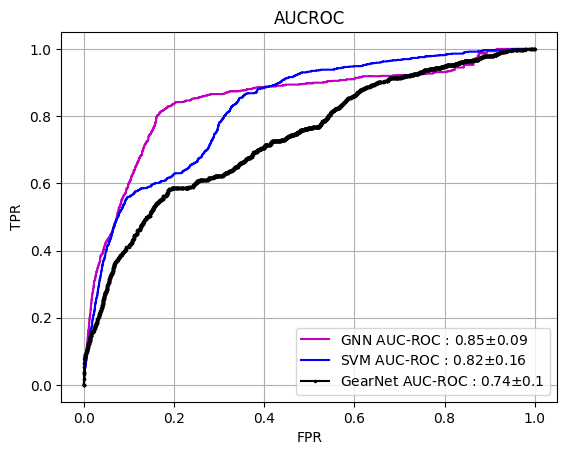

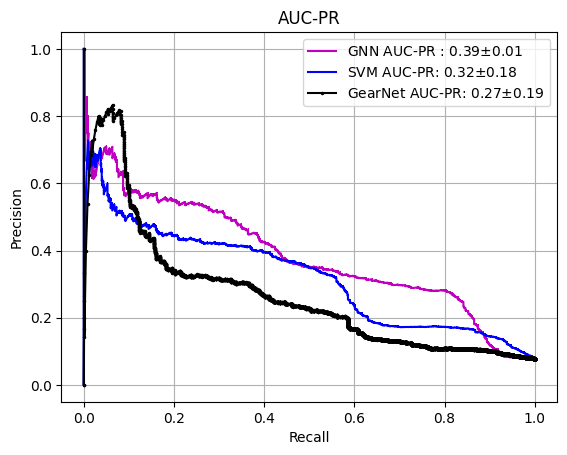

In [13]:
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score,precision_recall_curve,auc
import matplotlib.pyplot as plt
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
Z_GearNet=np.load(path+'onlyGearnet_Scores.npy')
Yo_GearNet=np.load(path+'onlyGearnet_Targets.npy')
####
fpr_GearNet, tpr_GearNet, thresholds_GearNet = roc_curve(Yo_GearNet, Z_GearNet)
Auc_GearNet = roc_auc_score(Yo_GearNet, Z_GearNet)
Auc_GearNet=(Auc_GearNet).round(2)
# calculate precision-recall curve
precision_GearNet, recall_GearNet, thresholds = precision_recall_curve(Yo_GearNet, Z_GearNet)
aucpr_GearNet=auc(recall_GearNet,precision_GearNet)
aucpr_GearNet=(aucpr_GearNet).round(2)
#######
Yo_SVM=np.load(path+'All_SVM_Targets.npy')
Z_SVM=np.load(path+'All_SVM_Scores.npy')
####
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(Yo_SVM, Z_SVM)
Auc_SVM = roc_auc_score(Yo_SVM, Z_SVM)
Auc_SVM=(Auc_SVM).round(2)
# calculate precision-recall curve
precision_SVM, recall_SVM, thresholds = precision_recall_curve(Yo_SVM, Z_SVM)
aucpr_SVM=auc(recall_SVM,precision_SVM)
aucpr_SVM=(aucpr_SVM).round(2)
#####Change this
Yo_GNN=np.load(path+'GNN-pipeline_Targets.npy')
Z_GNN=np.load(path+'GNN-pipeline_Scores.npy')
##########
fpr_GNN, tpr_GNN, thresholds_GNN = roc_curve(Yo_GNN, Z_GNN)
Auc_GNN= roc_auc_score(Yo_GNN, Z_GNN)
Auc_GNN=(Auc_GNN).round(2)
# calculate precision-recall curve
precision_GNN, recall_GNN, thresholds = precision_recall_curve(Yo_GNN, Z_GNN)
aucpr_GNN=auc(recall_GNN,precision_GNN)
aucpr_GNN=(aucpr_GNN).round(2)
###### GNN LOCO average 0.8576 ± 0.0923 0.4366 ± 0.2003
##### SVM LOCO average 0.7445 ± 0.1958 0.3312 ± 0.2017
fig = plt.figure()
Auc_GNN_std,PR_GNN_std,Auc_SVM_std,PR_SVM_std=0.0923,0.01,0.16,0.18
Auc_GearNet_std,PR_GearNet_std=0.1,0.19
#text="There is an upcoming task in %d days at %d cluster!" %a %cluster
plt.plot(fpr_GNN,tpr_GNN,color='m',marker=',',markersize=2,label = ('GNN AUC-ROC : $ {} ± {}$').format(round(Auc_GNN,2), round(Auc_GNN_std,2)))
plt.plot(fpr_SVM,tpr_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-ROC : $ {} ± {}$').format(round(Auc_SVM,2), round(Auc_SVM_std,2)))
plt.plot(fpr_GearNet,tpr_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-ROC : $ {} ± {}$').format(round(Auc_GearNet,2),round(Auc_GearNet_std,2)))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUCROC SVM and GNN-base model PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
#########
fig = plt.figure()
plt.plot(recall_GNN,precision_GNN,color='m',marker=',',markersize=2,label=('GNN AUC-PR : $ {} ± {}$').format(round(aucpr_GNN,2), round(PR_GNN_std,2)))
plt.plot(recall_SVM,precision_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-PR: $ {} ± {}$').format(round(aucpr_SVM,2), round(PR_SVM_std,2)))
plt.plot(recall_GearNet,precision_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-PR: $ {} ± {}$').format(round(aucpr_GearNet,2), round(PR_GearNet_std,2)))
plt.title('AUC-PR');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUC-PR SVM and GNN-base model PPI Inhibitors  Random and Binders combine.pdf", bbox_inches='tight')